In [88]:
%matplotlib inline
import os
import sys

sys.path.append("/home/pkarpov/Sapsan")

from sapsan.lib.backends import MLflowBackend, FakeBackend
from sapsan.lib.data import HDF5Dataset, EquidistantSampling, flatten
#from sapsan.lib.estimator.cnn.cnn3d_estimator import CNN3d, CNN3dConfig
from sapsan.lib import Train, Evaluate

In [89]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython import display
import numpy as np

def plot_params():
    params = {'font.size': 14, 'legend.fontsize': 14, 
              'axes.labelsize': 20, 'axes.titlesize':24,
              'xtick.labelsize': 17,'ytick.labelsize': 17,
              'axes.linewidth': 1, 'patch.linewidth': 3, 'lines.linewidth': 3,
              'xtick.major.width': 1.5,'ytick.major.width': 1.5,
              'xtick.minor.width': 1.25,'ytick.minor.width': 1.25,
              'xtick.major.size': 7,'ytick.major.size': 7,
              'xtick.minor.size': 4,'ytick.minor.size': 4,
              'xtick.direction': 'in','ytick.direction': 'in',              
              'axes.formatter.limits' : [-7, 7], 
              'axes.grid':True, 'grid.linestyle': ':', 'grid.color':'#999999',
              'text.usetex': False}              
    return params

class shock:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.shock_i = 0
        self.shock_r = 0
        
    def plot_plt(self, label=0, title='', shock=False, log='loglog', refresh=True, **kwargs):
        style = 'tableau-colorblind10'
        mpl.style.use(style)
        mpl.rcParams.update(plot_params())   

        plt.figure(figsize=(10,6))
        plt.gca().cla() 
        if log=='loglog': plt.loglog(self.x, self.y, label=label)
        elif log=='semilog': plt.semilogx(self.x, self.y, label=label)
        else: plt.plot(self.x, self.y, label=label)
            
        self.shock_position_rev()
        plt.axvline(self.shock_r, color='tab:red', label='shock')
        
        plt.legend(loc=3)
        
        if 'xmin' in kwargs: xmin = kwargs['xmin']
        if 'xmax' in kwargs: xmax = kwargs['xmax']; plt.xlim(xmin, xmax)
        if 'ymin' in kwargs: ymin = kwargs['ymin']
        if 'ymax' in kwargs: ymax = kwargs['ymax']; plt.ylim(ymin, ymax)
        
        plt.xlabel('r')
        plt.ylabel('Velocity')
        plt.title(title)
        if refresh:
            display.clear_output(wait=True)
            display.display(plt.gcf()) 
        return plt
    
    def shock_position(self):    
        self.shock_r = 0
        self.shock_i = np.argmin(self.y)
        self.shock_r = self.x[self.shock_i]
        #print('shock position: %.2e'%self.shock_r, self.shock_i)
        
def pns_radius(rho, rho_threshold=5e10):    
    for i in range(len(rho)-1,-1,-1):
        if rho[i] >= rho_threshold:
            pns_x = rho[i]
            pns_ind = i
            break
    return pns_ind

def get_numfiles(base, base_file):
    numfiles = len([filename for filename in os.listdir(f'{base}') if base_file in filename])
    return numfiles

In [90]:
def process_var(var, v, new_r, pns_i,shock_i):
    f = interpolate.interp1d(np.arange(len(v))[pns_i:shock_i+1], var[pns_i:shock_i+1])
    return f(new_r)

def interp_var(x, y, mlin_grid_size):
    mlin_x = np.zeros((x.shape[0], x.shape[1], mlin_grid_size))
    if y.any()!=None: mlin_y = np.zeros((y.shape[0], y.shape[1], mlin_grid_size))
    for i in range(x.shape[0]):
        v = x[i,0]
        sh = shock(np.arange(len(v)), v)
        sh.shock_position()
        #print(sh.shock_i, sh.shock_r)
        pns_i = pns_radius(x[i,1], rho_threshold=1e14)
        new_r = np.linspace(pns_i,sh.shock_i,mlin_grid_size)

        if y.any()!=None: mlin_y[i,0] = process_var(y[i,0], v, new_r, pns_i,sh.shock_i)        
        
        for j in range(x.shape[1]): 
            mlin_x[i,j] = process_var(x[i,j], v, new_r, pns_i,sh.shock_i)
            
        print('Convective region from/to: ',pns_i, sh.shock_i)

    if y.any()!=None: return mlin_x, mlin_y, pns_i,sh.shock_i
    else: return mlin_x, pns_i,sh.shock_i

In [91]:
# Resolution: 678x128x256 (r x theta x phi): r, pi and 2pi respectively
# outter radius is 2e4 km (2e9 cm)

#comp0: Ye
#eos0: gas pressure
#eos1: sound speed
#eos2: Temperature
#eos3: entropy
#eos4: gamma_1
#The rad variables of relevance are Erad0, Erad1, Erad2 (0, 1, 2 corresponding to electron neutrinos, electron anti-neutrinos, and heavy neutrinos) energy densitivies, and analgously for Frad0,1,2.

#['Flux0_0', 'Flux0_1', 'Flux0_2', 'Flux1_0', 'Flux1_1', 'Flux1_2', 
#'Flux2_0', 'Flux2_1', 'Flux2_2', 'Pturb_s2', 'Time', 'comp0', 
#'eos0', 'eos1', 'eos2', 'eos3', 'eos4', 
#'lapse', 'lapse_edge', 'rho', 'u', 'u1', 'u2', 'u3', 
#'velocity0', 'velocity1', 'velocity2']

#path = "data/t{checkpoint:1.0f}/{feature}_dim32_fm15.h5"

smass = 's16.0'
base_path = '/home/pkarpov/scratch/adam'
dataset = f'{smass}.swbj15.horo.3d/'
base = f'{base_path}/{dataset}'

path = base+"dump_{checkpoint:05d}.h5"

# velocity, rho, P_gas, Vsound, T, entropy
features_label = ['u1','rho','eos0','eos2']#,'eos1']#,'eos3']
target_label = ['Pturb_s2']
#target_label = ['u1']
target = ['dummy']

#Dimensionality of your data in format (D,H,W)
INPUT_SIZE = [678]

mlin_grid_size = 200

#Reduce dimensionality to the following in format (D,H,W)
#SAMPLE_TO = (16,16,16)

#Sampler to use for reduction
#sampler = EquidistantSampling(SAMPLE_TO)

In [92]:
from scipy import interpolate
import numpy as np
# checkpoints = [30,40,50,60,70,80,90,100,110,
#                120,130,140,150,160,170,180,200,210,
#                115,125,135,145,155,165,175,
#                35,65,117,127,137,147]#,180,
#                #187,200,210]#,220,230,240,250,260,
#                #270,280,290,300]
# #checkpoints = [100]

# Assign training checkpoints (15% of the total number)
numfiles = get_numfiles(base, 'dump_')
start = 30
interval          = int((numfiles-start)/(numfiles*0.10))
train_files       = int((numfiles-start)/interval)
train_files_early = int(train_files*1/3)
train_files_late  = int(train_files*2/3)

interval_early    = int(np.rint(((numfiles-start)/2)/train_files_early))
interval_late     = int(np.rint(((numfiles-start)/2)/train_files_late))
checkpoints_early = [i for i in range(start, int((numfiles-start)/2),    interval_early)]
checkpoints_late  = [i for i in range(int((numfiles-start)/2), numfiles, interval_late )]
checkpoints       = checkpoints_early + checkpoints_late

# 30% of the training dataset are used for validation 
valid = int(len(checkpoints)*0.3)
checkpoints_valid = [checkpoints[i]+1 for i in range(0,len(checkpoints),int(len(checkpoints)/valid))]
checkpoints += checkpoints_valid

# ----- Shift over missing files -----
files = [filename[5:10] for filename in os.listdir(f'{base}') if 'dump_' in filename]
files = [int(i) for i in files]
for i in range(len(files)-1):
    if files[i+1]-files[i] != 1: gap_file = files[i+1]

count = 0
for i,ch in enumerate(checkpoints):
    if ch not in files:
        print(i,ch)
        add = gap_file - checkpoints[i] + count
        checkpoints[i] += add
        count += 2
        
print(f' Checkpoints:    {numfiles}\n',
       f'For Training:   {len(checkpoints_early + checkpoints_late)}\n',
       f'For Validation: {len(checkpoints_valid)}\n',
       f'Checkpoints:    {checkpoints}\n')        

# ----- Load the Data -----

grid = HDF5Dataset(path           = base+'grid.h5',
                   features_label = ['Z'],
                   checkpoints    = [0],
                   input_size     = INPUT_SIZE)
r = grid.load_numpy().flatten()[:-1]

grid = HDF5Dataset(path           = path,
                   features_label = ['u1','rho','eos1'],
                   checkpoints    = checkpoints,
                   input_size     = INPUT_SIZE)
extra = grid.load_numpy()

u1     = np.expand_dims(extra[:,0], axis=1)
rho    = np.expand_dims(extra[:,1], axis=1)
vsound = np.expand_dims(extra[:,2], axis=1)
mach2  = np.square(u1/vsound)

extra[:,-1,:] = mach2[:,0,:]

# print(mach2.shape, f'{np.amax(mach2):.3e}')
# print(extra.shape)
# sys.exit()

# if 'u1' in features_label[i]: mlin_x[:,i] = np.square(mlin_x[:,i]/vsound[:,0])

extra_x, extra_y, pns_i, shock_i = interp_var(extra, extra, mlin_grid_size)

u1     = np.expand_dims(extra_x[:,0], axis=1)
rho    = np.expand_dims(extra_x[:,1], axis=1)
mach2  = np.expand_dims(extra_x[:,2], axis=1)

# print(extra_x.shape, vsound.shape)
# sys.exit()

data_loader = HDF5Dataset(path=path,                         
                          features_label=['Time'],                          
                          checkpoints=checkpoints,
                          input_size=INPUT_SIZE,                          
                          shuffle = False,
                          train_fraction = len(checkpoints)-len(checkpoints_valid))
time = data_loader.load_numpy()[0,0,0]

#Load the data
data_loader = HDF5Dataset(path=path,
                          target=target,
                          features_label=features_label,
                          target_label=target_label,
                          checkpoints=checkpoints,
                          input_size=INPUT_SIZE,
                          #sampler=sampler,
                          shuffle = False,
                          train_fraction = len(checkpoints)-len(checkpoints_valid))

x, y = data_loader.load_numpy()
    
# print(x.shape)
# sys.exit()

mlin_x, mlin_y, pns_i, shock_i = interp_var(x, y, mlin_grid_size)    

#mlin_xt, mlin_yt, pns_i, shock_i = interp_var(mlin_x, mlin_y, 214)

print('shapes', x.shape,y.shape)
print('mlin_x', mlin_x.shape,mlin_y.shape)
#print('mlin_xt', mlin_xt.shape,mlin_yt.shape)

#mlin_x = mlin_x[:,2:3,:]

# Conversions in Fortran
#                      write(69,103)i,encm(i),1.d9*x(i),2.d6*rho(i),      &
# !     &                    1.d8*v(i),ye(i),1.d16*pr(i)!,                  &
#      &                    1.d8*v(i),ye(i),2.d22*pr(i),                  &
#      &                    1.d9*temp(i)   

# I think Adam's dataset uses 1e9 k for T units

units = {'u1'   : 1,#1e-8,
         'mach2': 1,
         'rho'  : 2e-13,#2e-6,
         'eos0' : 2e-32,
         'eos1' : 1e-8,
         'eos2' : 1,
         'eos3' : 1,
         target_label[0]:1e1
         }

for i in range(mlin_x.shape[1]):
    if 'eos0' in features_label[i]: mlin_y[:,0] = mlin_y[:,0]/mlin_x[:,i] * units[target_label[0]]        
    elif 'u1' in features_label[i]: mlin_x[:,i] = mach2[:,0,:]
    mlin_x[:,i] *= units[features_label[i]]
    print(f'{features_label[i]} min: {np.amin(mlin_x[:,i]):.3e}, max: {np.amax(mlin_x[:,i]):.3e}')   

print(f'Pturb/Pgas min: {np.amin(mlin_y[:,:]):.3e}, max: {np.amax(mlin_y[:,:]):.3e}')

#mlin_x = np.delete(mlin_x, 1, axis=1)

loaders = data_loader.convert_to_torch([mlin_x, mlin_y])
print('Time %.2f ms'%(time*1e3))
print(pns_i, shock_i, r[pns_i], r[shock_i])

 Checkpoints:    158
 For Training:   19
 For Validation: 7
 Checkpoints:    [30, 43, 56, 64, 70, 76, 82, 88, 94, 100, 106, 112, 118, 124, 130, 136, 142, 148, 154, 31, 65, 83, 101, 119, 137, 155]

Features:  ['None']
Fetures_label: ['Z']
Loading 'Z' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/grid.h5'
----------
Features:  ['None']
Fetures_label: ['u1', 'rho', 'eos1']
Loading 'u1' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/dump_00030.h5'
----------
Loading 'rho' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/dump_00030.h5'
----------
Loading 'eos1' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/dump_00030.h5'
----------
Loading 'u1' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/dump_00043.h5'
----------
Loading 'rho' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/dump_00043.h5'
----------
Loading 'eos1' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/dump_00043.h5'
----------
Loading 'u1' from fi

In [6]:
import h5py
with h5py.File(base+'grid.h5', 'r') as hf:
    print(hf.keys())
    vol = hf['volume']
    z = hf['Z']
    print(vol.shape,z.shape)    

with h5py.File(base+'dump_00009.h5', 'r') as hf:
    print(hf.keys())    
    Pturb = hf['Pturb_s2']
    v = hf['velocity0']
    print(v.shape, Pturb.shape)

<KeysViewHDF5 ['X', 'Y', 'Z', 'area0', 'area1', 'area2', 'gcov0', 'gcov1', 'gcov2', 'mask', 'volume']>
(678,) (679,)
<KeysViewHDF5 ['Flux0_0', 'Flux0_1', 'Flux0_2', 'Flux1_0', 'Flux1_1', 'Flux1_2', 'Flux2_0', 'Flux2_1', 'Flux2_2', 'Pturb_s2', 'Time', 'comp0', 'eos0', 'eos1', 'eos2', 'eos3', 'eos4', 'lapse', 'lapse_edge', 'rho', 'u', 'u1', 'u2', 'u3', 'velocity0', 'velocity1', 'velocity2']>
(678,) (678,)


In [93]:
import json
import numpy as np
import sys
import os

import torch
from torch.autograd import Variable
from torch.utils import data
from torch.utils.data import DataLoader

from sapsan.core.models import EstimatorConfig
from sapsan.lib.estimator.torch_backend import TorchBackend
from sapsan.lib.data import get_loader_shape

from sapsan.lib.estimator.torch_modules import Interp1d
from sapsan.lib.estimator.torch_modules import Gaussian

class PIMLTurbModel(torch.nn.ModuleDict):
    def __init__(self, D_in = 1, D_out = 1, activ = "ReLU", sigma=1):
        super(PIMLTurbModel, self).__init__()       
        
        D_out=200
            
        self.conv1d = torch.nn.Conv1d(D_in, D_in*2, kernel_size=2, stride=2)
        #self.conv3d = torch.nn.Conv3d(D_in, D_in*2, kernel_size=2, stride=1)

        self.pool = torch.nn.MaxPool1d(kernel_size=2)

        self.activation = getattr(torch.nn, activ)()

        #self.linear = torch.nn.Linear(D_in*8, D_in*16)
        self.linear = torch.nn.Linear(D_in*100, D_in*200)
        self.linear2 = torch.nn.Linear(D_in*200, D_out)
        
        self.gaussian = Gaussian(sigma=1)

    def forward(self, x):         
        #x = x.double()
        x = x.float()
        x_shape = x.size()
        
        show = False
        if show: print(x_shape)
        x = self.conv1d(x)        
        if show: print(x.size())
        x = self.pool(x)
        if show: print(x.size())
        
        x = self.activation(x) 
        x = x.view(x.size(0), -1)
        if show: print(x.size())
        x = self.linear(x)
        if show: print(x.size())
        x = self.activation(x)
        x = self.linear2(x) 
        
        x_shape = list(x_shape)
        #del x_shape[1]
        x_shape[1]=1
        x = torch.reshape(x,x_shape)  
        if show: print(x.size())        
        x = torch.mul(x,x)
        #x = torch.sqrt(x)
        if show: print(x.size())
        #x = self.gaussian(x)
        return x          

class SmoothL1_KSLoss(torch.nn.Module):
    '''
    The loss functions combines a statistical (Kolmogorov-Smirnov)
    and a spatial loss (Smooth L1).
    
    Corresponding 'train_l1ks_log.txt' and 'valid_l1ks_log.txt'
    are written out to include the individual loss evolutions.
    '''    
    def __init__(self, ks_stop, ks_frac, ks_scale, l1_scale, beta, train_size, valid_size):
        super(SmoothL1_KSLoss, self).__init__()
        self.first_write = True
        self.first_iter = True
        self.ks_stop = ks_stop
        self.ks_frac = ks_frac
        self.ks_scale = ks_scale        
        self.l1_scale = l1_scale
        self.beta = beta
        self.train_size = train_size
        self.valid_size = valid_size
        self.stop = False   
        
    def write_log(self, losses):
        if self.first_write:
            if os.path.exists(self.log_fname): os.remove(self.log_fname)
        
        with open(self.log_fname,'a') as f:
            if self.first_write:
                f.write(f"mean(L1_loss) \t mean(KS_loss) "\
                        f"\t mean(L1_loss)*{self.l1_scale:.3e} \t mean(KS_loss)*{self.ks_scale:.3e}")
            f.write("\n")
            np.savetxt(f, losses.detach().cpu().numpy(), fmt='%.3e', newline="\t")
            
    def forward(self, predictions, targets, write, write_idx):  
        if predictions.is_cuda:
            self.device = torch.device('cuda:%d'%predictions.get_device()) 
        else: self.device = torch.device('cpu')       
        
        #-----SmoothL1----
        l1_loss = 0

        self.beta = 0.1*targets.max()
        diff = predictions-targets
        mask = (diff.abs() < self.beta)
        l1_loss += mask * (0.5*diff**2 / self.beta)
        l1_loss += (~mask) * (diff.abs() - 0.5*self.beta)
           
        #--------KS-------
        distr = torch.distributions.normal.Normal(loc=targets.mean(), 
                                                  scale=targets.std(), 
                                                  validate_args=False)  
        cdf,idx = distr.cdf(targets).flatten().to(self.device).sort()
        
        distr = torch.distributions.normal.Normal(loc=predictions.mean(), 
                                                  scale=predictions.std(), 
                                                  validate_args=False) 
        cdf_pred,idx_pred = distr.cdf(predictions).flatten().to(self.device).sort()     
                                
        vals,idx = targets.flatten().to(self.device).sort()
        vals_pred,idx_pred = predictions.flatten().to(self.device).sort()        

        cdf_interp = Interp1d()(vals_pred, cdf_pred, vals)[0]       
        
        ks_loss = torch.max(torch.abs(cdf-cdf_interp)).to(self.device)           
        
        #--Print Metrics-- 
        if self.first_iter:
            self.maxl1 = l1_loss.mean().detach()                      
            self.maxks = ks_loss.mean().detach()
            self.max_ratio = self.maxks/self.maxl1
                        
            print('---Initial (max) L1, KS losses and their ratio--')
            print(self.maxl1, self.maxks, self.max_ratio)
            print('------------------------------------------------')
            
            self.first_iter = False

        #----Calc Loss----
        #fractions that KS and L1 contribute to the total loss        
        l1_frac = 1-self.ks_frac
        
        loss = (l1_frac*l1_loss.mean()*self.l1_scale +
                self.ks_frac*ks_loss.mean()*self.ks_scale)
        
        #---Save Batch----
        if write_idx == 0:
            if write == 'train': 
                self.batch_size = self.train_size
                self.log_fname = "train_l1ks_log.txt"
            elif write == 'valid': 
                self.batch_size = self.valid_size 
                self.log_fname = "valid_l1ks_log.txt"                
            self.iter_losses_l1 = torch.zeros(self.batch_size,requires_grad=False).to(self.device)
            self.iter_losses_ks = torch.zeros(self.batch_size,requires_grad=False).to(self.device)
        
        self.iter_losses_l1[write_idx] = l1_loss.mean().detach()
        self.iter_losses_ks[write_idx] = ks_loss.mean().detach()
        
        #---Write Logs----
        if write_idx == (self.batch_size-1):
            mean_iter_l1 = self.iter_losses_l1.mean()
            mean_iter_ks = self.iter_losses_ks.mean()
            
            if (mean_iter_ks < self.ks_stop and write == 'valid') or self.stop==True:
                self.stop = True
            
            self.write_log(torch.tensor([mean_iter_l1, mean_iter_ks,
                                         mean_iter_l1*self.l1_scale,
                                         mean_iter_ks*self.ks_scale]))      
            if write == 'valid': self.first_write = False                  
        
        return loss, self.stop
    
class PIMLTurbConfig(EstimatorConfig):
    def __init__(self,
                 n_epochs: int = 1,
                 patience: int = 10,
                 min_delta: float = 1e-5, 
                 logdir: str = "./logs/",
                 lr: float = 1e-3,
                 min_lr = None,                 
                 *args, **kwargs):
        self.n_epochs = n_epochs
        self.logdir = logdir
        self.patience = patience
        self.min_delta = min_delta
        self.lr = lr
        if min_lr==None: self.min_lr = lr*1e-2
        else: self.min_lr = min_lr        
        self.kwargs = kwargs
        self.parameters = {f'model - {k}': v for k, v in self.__dict__.items() if k != 'kwargs'}
        if bool(self.kwargs): self.parameters.update({f'model - {k}': v for k, v in self.kwargs.items()})          
    
class PIMLTurb(TorchBackend):
    def __init__(self, activ, loss,
                       loaders,
                       ks_stop = 0.1,
                       ks_frac = 0.5,
                       ks_scale = 1,
                       l1_scale = 1,                 
                       l1_beta = 1,
                       sigma = 1,
                       config = PIMLTurbConfig(), 
                       model = PIMLTurbModel()):
        super().__init__(config, model)
        self.config = config
        self.loaders = loaders
        self.device = self.config.kwargs['device']
        self.ks_stop = ks_stop
        self.ks_frac = ks_frac
        self.ks_scale = ks_scale
        self.l1_scale = l1_scale        
        self.beta = l1_beta
        
        x_shape, y_shape = get_loader_shape(self.loaders)                

        self.model = PIMLTurbModel(x_shape[1], y_shape[2]**3, activ, sigma)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config.lr)        
        
        if loss == "SmoothL1_KSLoss": 
            self.loss_func = SmoothL1_KSLoss(ks_stop = self.ks_stop, ks_frac = self.ks_frac,
                                             ks_scale = self.ks_scale, l1_scale = self.l1_scale, 
                                             beta = self.beta,
                                             train_size = len(self.loaders['train']), 
                                             valid_size = len(self.loaders['valid']))
        else: 
            print("This network only supports the custom SmoothL1_KSLoss. Please set the 'loss' parameter in config")
            sys.exit()
        
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                               patience=self.config.patience,
                                                               min_lr=self.config.min_lr) 
        self.config.parameters["model - loss"] = str(self.loss_func).partition("(")[0]
        self.config.parameters["model - activ"] = activ
        
    def write_loss(self, losses, epoch, fname_train = "train_log.txt", fname_valid='valid_log.txt'):
        for idx, fname in enumerate([fname_train, fname_valid]):
            if epoch==1:
                if os.path.exists(fname): os.remove(fname)

            with open(fname,'a') as f:
                if epoch == 1: f.write("epoch \t loss")
                f.write("\n")
                np.savetxt(f, [[losses[0],losses[idx+1]]], fmt='%d \t %.3e', newline="\t")
        
    def train(self):    
        self.model = self.model#.double()
        self.model.to(self.device)
        
        if 'cuda' in str(self.device):
            self.optimizer_to(self.optimizer, self.device)      
            
        for epoch in np.linspace(1,int(self.config.n_epochs),int(self.config.n_epochs), dtype='int'):     
            iter_loss = np.zeros(len(self.loaders['train']))
            for idx, (x, y) in enumerate(self.loaders['train']):
                x = x.to(self.device)
                y = y.to(self.device)
                
                y_pred = self.model(x)
                loss, stop = self.loss_func(y_pred, y, 'train', idx)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                iter_loss[idx] = loss.item()
                        
            epoch_loss = iter_loss.mean()
            print(f'train ({epoch}/{int(self.config.n_epochs)}) loss: {epoch_loss:.4e}')
                        
            with torch.set_grad_enabled(False):
                iter_loss_valid = np.zeros(len(self.loaders['valid']))
                for idx, (x, y) in enumerate(self.loaders['valid']):
                    x = x.to(self.device)
                    y = y.to(self.device)

                    y_pred = self.model(x)                                    
                    
                    loss_valid, stop = self.loss_func(y_pred, y, 'valid', idx)

                    iter_loss_valid[idx] = loss_valid.item()

                epoch_loss_valid = iter_loss_valid.mean()
                print(f'valid ({epoch}/{int(self.config.n_epochs)}) loss: {epoch_loss_valid:.4e}')
            
            self.write_loss([epoch, epoch_loss, epoch_loss_valid], epoch)            
            
            if stop:
                print('Reached sufficient KS Loss, stopping...')
                break
                    
            print('-----')  

        with open('model_details.txt', 'w') as file:                    
            file.write('%s\n\n%s\n\n%s'%(str(self.model),
                                   str(self.optimizer),
                                   str(self.scheduler)))
                
        return self.model

In [94]:
#estimator = CNN3d(config = CNN3dConfig(n_epochs=5, patience=10, min_delta=1e-5),
#                  loaders = loaders)

# print(f'Target: {torch.amin(targets):.2e}, {torch.amax(targets):.2e}')
# print(f'Predic: {torch.amin(predictions):.2e}, {torch.amax(predictions):.2e}')

lr = 1e-4
#loss = "SmoothL1Loss"
#loss = "CustomLoss"
#loss = "KSLoss2"
loss = "SmoothL1_KSLoss"
#loss = "MSELoss"
#loss = "BCELoss"
#loss = "BCEWithLogitsLoss"
#activ = "LogSigmoid"
activ = "Tanhshrink"
#activ = "Sigmoid"
#activ = "ReLU"
ks_stop  = 0.012
l1_scale = 1e3#e-15
ks_scale = 1#5e8#5e16

mlflow = True
#mlflow = False
if mlflow: 
    experiment_name  = smass
    tracking_backend = MLflowBackend(experiment_name, host="localhost",port=5000)
else: tracking_backend = FakeBackend()

estimator = PIMLTurb(
        config   = PIMLTurbConfig(n_epochs=1000, patience=10, 
                                  min_delta=1e15, lr=lr, min_lr=lr*1e-5, 
                                  device='cpu', loader_key='train'),
        loaders  = loaders,
        activ    = activ, 
        loss     = loss,
        ks_stop  = ks_stop,
        l1_scale = l1_scale,
        ks_scale = ks_scale,
        l1_beta  = 1,
        sigma    = 1)    

localhost:5000 is busy, checking if it is MLflow...
mlflow ui is already running at localhost:5000


In [95]:
#--- Train the model ---
#Set the experiment
    
training_experiment = Train(model           = estimator,
                            backend         = tracking_backend,
                            data_parameters = data_loader)

#Train the model
estimator = training_experiment.run()
if mlflow: 
    tracking_backend.log_parameter("ks_stop",  ks_stop)
    tracking_backend.log_parameter("ks_scale", ks_scale)
    tracking_backend.log_parameter("l1_scale", l1_scale)    

---Initial (max) L1, KS losses and their ratio--
tensor(0.2686) tensor(0.2507) tensor(0.9335)
------------------------------------------------
train (1/1000) loss: 5.5361e+01
valid (1/1000) loss: 3.5529e+01
-----
train (2/1000) loss: 3.7423e+01
valid (2/1000) loss: 1.8006e+01
-----
train (3/1000) loss: 2.1757e+01
valid (3/1000) loss: 1.9117e+01
-----
train (4/1000) loss: 2.0449e+01
valid (4/1000) loss: 1.3237e+01
-----
train (5/1000) loss: 1.5421e+01
valid (5/1000) loss: 1.9714e+01
-----
train (6/1000) loss: 1.7043e+01
valid (6/1000) loss: 1.2718e+01
-----
train (7/1000) loss: 1.2691e+01
valid (7/1000) loss: 1.6770e+01
-----
train (8/1000) loss: 1.4672e+01
valid (8/1000) loss: 1.3942e+01
-----
train (9/1000) loss: 1.3814e+01
valid (9/1000) loss: 1.8084e+01
-----
train (10/1000) loss: 1.8129e+01
valid (10/1000) loss: 1.3945e+01
-----
train (11/1000) loss: 1.0499e+01
valid (11/1000) loss: 1.1553e+01
-----
train (12/1000) loss: 1.0875e+01
valid (12/1000) loss: 1.3811e+01
-----
train (13/1

In [96]:
from sapsan.utils.plot import log_plot
#plotting training results
#Note: not done automatically since Catalyst is NOT used
log = log_plot(show_log       = True,
               log_path       = 'train_log.txt', 
               valid_log_path = 'valid_log.txt', 
               delimiter      = '\t')
log_name = "runtime_log.html"
if mlflow:
    log.write_html(log_name)
    tracking_backend.log_artifact(log_name)

#--------------------------------------------------
#plotting individual evolutions of L1 and KS losses
#Note: the individual losses are not logged at every epoch
#mean(L1_loss)    mean(KS_loss)
#mean(L1_loss)*{self.scalel1:.3e}     mean(KS_loss)*{self.scalel1:.3e}
losses = [[f"mean(L1_loss)", f"mean(L1_valid)"],
          [f"mean(KS_loss)", f"mean(KS_valid)"]]

for idx, (train_name, valid_name) in enumerate(losses):
    if   'L1' in train_name: idx = 2 #plotting scaled L1
    elif 'KS' in train_name: idx = 1
    log = log_plot(show_log       = True, 
                   valid_log_path = 'valid_l1ks_log.txt',
                   log_path       = 'train_l1ks_log.txt',
                   delimiter      = '\t',
                   train_name     = train_name, 
                   valid_name     = valid_name,
                   train_column   = idx, 
                   valid_column   = idx, 
                   epoch_column   = None)
    log_name = f"{train_name}.html"
    if mlflow:
        log.write_html(log_name)    
        tracking_backend.log_artifact(log_name) 

In [72]:
# Save model in raw and TorchScript
# def check_path(path):
#     if not os.path.exists(path):
#         os.makedirs(path)

# ml_savepath = f'mlmodels/{smass}'
# check_path(ml_savepath)
# estimator.save(path = ml_savepath)
# estimator.save(path = ml_savepath, script=True)

Features:  ['None']
Fetures_label: ['u1', 'rho', 'eos1']
Loading 'u1' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/dump_00150.h5'
----------
Loading 'rho' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/dump_00150.h5'
----------
Loading 'eos1' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/dump_00150.h5'
----------
Convective region from/to:  20 240
Features:  ['None']
Fetures_label: ['u1', 'rho', 'eos0', 'eos2']
Loading 'u1' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/dump_00150.h5'
----------
Loading 'rho' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/dump_00150.h5'
----------
Loading 'eos0' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/dump_00150.h5'
----------
Loading 'eos2' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/dump_00150.h5'
----------
Loading 'Pturb_s2' from file '/home/pkarpov/scratch/adam/s16.0.swbj15.horo.3d/dump_00150.h5'
----------
Convective region from/to:  20 240
u1 min: 1.

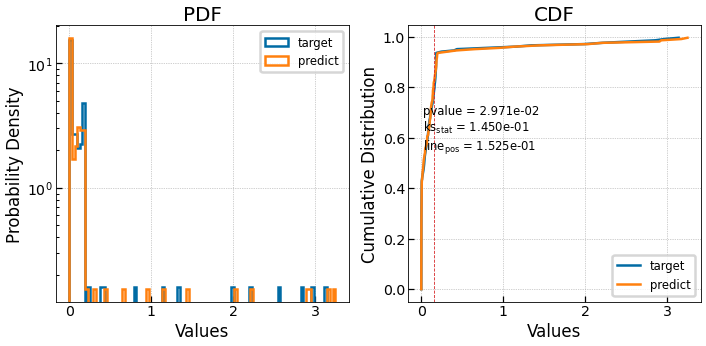

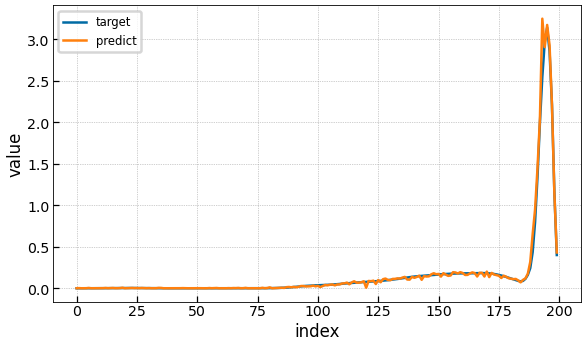

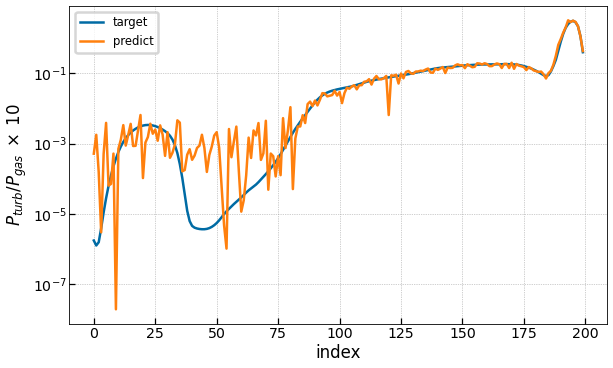

In [73]:
%matplotlib inline

import mlflow as mlf

target_checkpoint = [150]

grid = HDF5Dataset(path           = path,
                   features_label = ['u1','rho','eos1'],
                   checkpoints    = target_checkpoint,
                   input_size     = INPUT_SIZE)
extra = grid.load_numpy()

u1     = np.expand_dims(extra[:,0], axis=1)
rho    = np.expand_dims(extra[:,1], axis=1)
vsound = np.expand_dims(extra[:,2], axis=1)
mach2  = np.square(u1/vsound)

extra[:,-1,:] = mach2[:,0,:]

extra_x, extra_y, pns_i, shock_i = interp_var(extra, extra, mlin_grid_size)

u1     = np.expand_dims(extra_x[:,0], axis=1)
rho    = np.expand_dims(extra_x[:,1], axis=1)
mach2  = np.expand_dims(extra_x[:,2], axis=1)


#--- Test the model ---
#Load the test data
data_loader_eval = HDF5Dataset(path           = path,
                               target         = target,
                               features_label = features_label,
                               target_label   = target_label,
                               checkpoints    = target_checkpoint,
                               input_size     = INPUT_SIZE)
x, y = data_loader_eval.load_numpy()

#x[:,3] = x[:,3]#/2e22
#y[:,0] = y[:,0]#/2e22

mlin_x, mlin_y, pns_i, shock_i = interp_var(x, y, mlin_grid_size)

for i in range(mlin_x.shape[1]):
    if 'eos0' in features_label[i]: mlin_y[:,0] = mlin_y[:,0]/mlin_x[:,i] * units[target_label[0]]                  
    elif 'u1' in features_label[i]: mlin_x[:,i] = mach2[:,0,:]
    mlin_x[:,i] *= units[features_label[i]]
    print(f'{features_label[i]} min: {np.amin(mlin_x[:,i]):.3e}, max: {np.amax(mlin_x[:,i]):.3e}')

print(f'Pturb min: {np.amin(mlin_y[:,:]):.3e}, max: {np.amax(mlin_y[:,:]):.3e}')
#mlin_x = np.delete(mlin_x, 1, axis=1)
loaders = data_loader_eval.convert_to_torch([mlin_x, mlin_y])

#Set the test experiment
estimator.loaders = loaders
data_loader_eval.input_size=[mlin_grid_size]
data_loader_eval.batch_size=[mlin_grid_size]

evaluation_experiment = Evaluate(model           = estimator,
                                 backend         = tracking_backend,
                                 data_parameters = data_loader_eval,
                                 )#pdf_xlim = (-0.5e7,2e7),
                                 #cdf_xlim = (-0.5e7,2e7))

#Test the model
#eval returns a dict, cubes = {'pred_cube':np.ndarray, 'target_cube':np.ndarray}
cubes = evaluation_experiment.run()

from sapsan.utils.plot import cdf_plot, pdf_plot, line_plot

targ = cubes['target']
pred = cubes['predict']

print(f'Target: {np.amin(targ):.2e}, {np.amax(targ):.2e}')
print(f'Predic: {np.amin(pred):.2e}, {np.amax(pred):.2e}')

ax = line_plot([[np.arange(mlin_grid_size),targ[0,0]/1e0],
                [np.arange(mlin_grid_size),pred[0,0]/1e0],
                ],label=['target', 'predict'],
                plot_type='semilogy', figsize = (10,6))
ax.set_xlabel('index')
ax.set_ylabel(r'$P_{turb}/P_{gas} \; \times \; $%.f'%units[target_label[0]])

if mlflow:
    run_id = evaluation_experiment.run_id
    tracking_backend.resume(run_id = run_id)
    logy_name = 'spatial_plot_logy.png'
    plt.savefig(logy_name)
    tracking_backend.log_artifact(logy_name) 
    
    # mlf.pytorch.log_model(estimator.model, "model")
    # model_uri = mlf.get_artifact_uri("model")         
    
    tracking_backend.end()       

In [8]:
from sapsan.lib.estimator import load_estimator

lr = 1e-4
#loss = "SmoothL1Loss"
#loss = "CustomLoss"
#loss = "KSLoss2"
loss = "SmoothL1_KSLoss"
#loss = "MSELoss"
#loss = "BCELoss"
#loss = "BCEWithLogitsLoss"
#activ = "LogSigmoid"
activ = "Tanhshrink"
#activ = "Sigmoid"
#activ = "ReLU"
ks_stop = 0.012
l1_scale = 1e3#e-15
ks_scale = 1#5e8#5e16

mlflow = True
#mlflow = False
if mlflow: 
    experiment_name = smass
    tracking_backend = MLflowBackend(experiment_name, host="localhost",port=5000)
else: tracking_backend = FakeBackend()

loaded_estimator = PIMLTurb(
        config = PIMLTurbConfig(n_epochs=1000, patience=10, 
                                min_delta=1e15, lr=lr, min_lr=lr*1e-5, 
                                device='cpu', loader_key='train'),
        loaders = loaders,
        activ=activ, loss=loss,
        ks_stop = ks_stop,
        l1_scale = l1_scale,
        ks_scale = ks_scale,
        l1_beta = 1,
        sigma = 1) 

estimator = load_estimator.load(f'mlmodels/{smass}', estimator = loaded_estimator)

localhost:5000 is busy, checking if it is MLflow...
mlflow ui is already running at localhost:5000


/home/pkarpov/Sapsan/sapsan/lib/estimator/torch_backend.py:231: UserWarning: WARNING: Could not load optimizer config. Only loading state_dict.
  warnings.warn('WARNING: Could not load optimizer config. Only loading state_dict.')


 Cell  M_enclosed [M_sol]  Radius [cm]  Rho [g/cm^3]  Velocity [cm/s]  Ye  Pressure [g/cm/s^2]  Temperature [K]  Sound [cm/s]  Entropy [kb/baryon]

Convective region from/to:  218 5109
coda vals (1, 4, 9000)
Convective region from/to:  218 5109
u1 min: 1.567e-08, max: 6.945e+01
rho min: 6.422e-05, max: 2.196e+01
eos0 min: 3.124e-06, max: 2.255e+01
eos2 min: 7.228e-01, max: 1.101e+01

 ====== run info ======
 Device used:  cpu
 DDP:          False
 
The data is 1D: plotting profiles...
eval - runtime:  0.016534090042114258
Predic: 2.92e-05, 7.78e+01


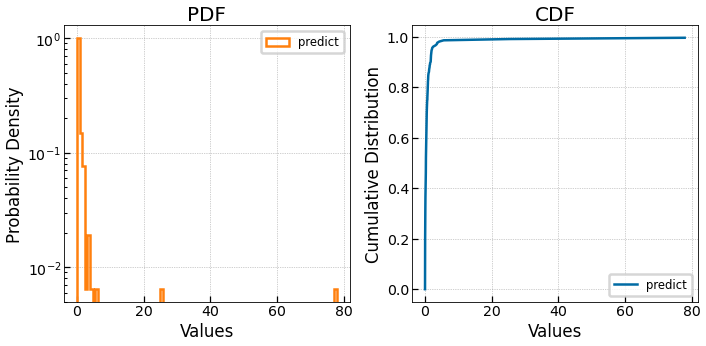

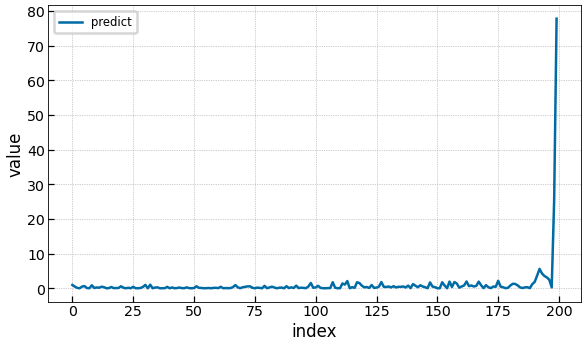

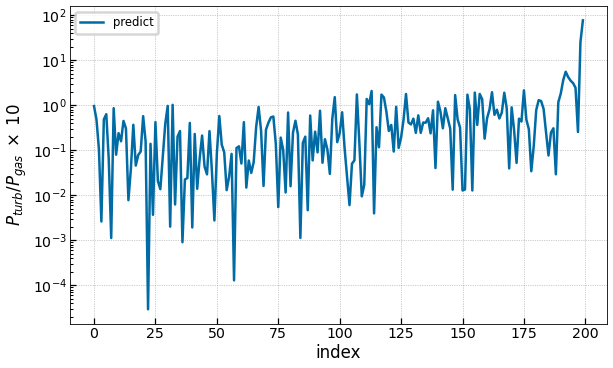

In [84]:
# Compare with a COLLAPSO1D output (preferrably of the same progenitor mass)

#base_path = '/home/pkarpov/COLLAPSO1D/project/1dmlmix/output/'
#base_path = '/home/pkarpov/scratch/1dccsn/sfho_s/encm_tuned/s19.0_g10k_c9.4k_p0.3k'#s19.0_g1.5k_c0.5k_p0.3k/'
base_path = '/home/pkarpov/scratch/1dccsn/sfho_s/encm_tuned/s16.0_g9k_c8.4k_p_0.3k'
base_file = 'DataOut_read'
dataset = 'DataOut'

i=660#710#580#700#490
    
file = f'{base_file}.{i}'
file1d = f'{base_path}/{file}'                        

with open(file1d, "r") as file:
    line = file.readline()        
    header_vals = file.readline()
    vals_strip = header_vals[:-1].split(' ')        
    time1d, bounce_time, pns_ind, pns_x, shock_ind, shock_x, rlumnue = [float(x) for x in vals_strip if x!='']        
    lumnue = rlumnue
    times = time1d    
    print(file.readline())
    
pns_ind = int(pns_ind)-1
shock_ind = int(shock_ind)-1
                
#print('Time %.2f ms'%(float(time1d)*1e3))

ps = np.loadtxt(file1d, skiprows=3)
ps = np.moveaxis(ps,0,1) 

# velocity, rho, P_gas, Vsound, T, entropy
#features_label = ['u1','rho','eos0','eos1','eos2','eos3']

#code_vals = np.array([ps[4],ps[3],ps[6],ps[vsound],ps[7],ps[entropy]])

ncell   = ps[0]
encm    = ps[1]
r       = ps[2]
rho     = ps[3]
v       = ps[4]
ye      = ps[5]
P       = ps[6]
T       = ps[7]*1e-9
vsound  = ps[8]

mach2   = np.square(v/vsound)

extra_x, pns_i, shock_i = interp_var(np.array([[v,rho,mach2]]), y, mlin_grid_size)
mach2  = np.expand_dims(extra_x[:,2], axis=1)

code_vals = np.array([[v,rho,P,T]])
print('coda vals', code_vals.shape)

#----------------------------------------------------------
y = np.array(None)

mlin_x, pns_i, shock_i = interp_var(code_vals, y, mlin_grid_size)

for i in range(mlin_x.shape[1]):
    if 'u1' in features_label[i]: mlin_x[:,i] = mach2[:,0,:]
    elif 'eos2' in features_label[i]: mlin_x[:,i] *= 1e-1
    mlin_x[:,i] *= units[features_label[i]]
    print(f'{features_label[i]} min: {np.amin(mlin_x[:,i]):.3e}, max: {np.amax(mlin_x[:,i]):.3e}')

#sys.exit()

loaders = data_loader_eval.convert_to_torch([mlin_x])

#Set the test experiment
estimator.loaders = loaders
data_loader_eval.input_size=[mlin_grid_size]
data_loader_eval.batch_size=[mlin_grid_size]

evaluation_experiment = Evaluate(model           = estimator,
                                 backend         = tracking_backend,
                                 data_parameters = data_loader_eval,
                                 run_name        = '1dccsn'
                                 )#pdf_xlim = (-0.5e7,2e7),
                                 #cdf_xlim = (-0.5e7,2e7))

#Test the model
#eval returns a dict, cubes = {'pred_cube':np.ndarray, 'target_cube':np.ndarray}
cubes = evaluation_experiment.run()

from sapsan.utils.plot import cdf_plot, pdf_plot, line_plot

pred = cubes['predict']

print(f'Predic: {np.amin(pred):.2e}, {np.amax(pred):.2e}')

ax = line_plot([
                [np.arange(mlin_grid_size),pred[0,0]/1e0],
                ],label=['predict'],
                plot_type='semilogy', figsize = (10,6))
ax.set_xlabel('index')
ax.set_ylabel(r'$P_{turb}/P_{gas} \; \times \; $%.f'%units[target_label[0]])

mlflow = False
if mlflow:
    run_id = evaluation_experiment.run_id
    tracking_backend.resume(run_id = run_id)
    logy_name = 'spatial_plot_logy.png' 
    plt.savefig(logy_name)
    tracking_backend.log_artifact(logy_name) 
    tracking_backend.end()    

In [65]:
# produce a movie of predictions on the full Adam's dataset

import os
import glob
from subprocess import Popen, PIPE

sols = {'s9.0': 155,
        's10.0': 420,
        's12.0': 211,
        's13.0': 529,
        's14.0': 529,
        's15.0': 55,
        's16.0': 157,
        's17.0': 157,
        's18.0': 157,
        's19.0': 210,
        's20.0': 314,
        's25.0': 309,
        's60.0': 400}    

start = checkpoints[0]
base_path = f'{smass}_plt'
if not os.path.exists(base_path): os.makedirs(base_path)

# movie parameters
name = f'{base_path}/spatial_1dccsn'
fps = 3

# clean up all .png files
fileList = glob.glob(f'{base_path}/*.png')
[os.remove(file) for file in fileList]

for i in range(start,sols[smass]):
    #path = base+"dump_{checkpoint:05d}.h5"
    
    data_loader_eval = HDF5Dataset(path=path,
                            target=target,
                            features_label=features_label,
                            target_label=target_label,
                            checkpoints=[i],
                            input_size=INPUT_SIZE)
    x, y = data_loader_eval.load_numpy()

    mlin_x, mlin_y, pns_i, shock_i = interp_var(x, y, mlin_grid_size)

    for j in range(mlin_x.shape[1]):
        if 'eos0' in features_label[j]: mlin_y[:,0] = mlin_y[:,0]/mlin_x[:,j] * units[target_label[0]]                  
        mlin_x[:,j] *= units[features_label[j]]
        #print(f'{features_label[j]} min: {np.amin(mlin_x[:,j]):.3e}, max: {np.amax(mlin_x[:,j]):.3e}')

    #print(f'Pturb min: {np.amin(mlin_y[:,:]):.3e}, max: {np.amax(mlin_y[:,:]):.3e}')
    mlin_x = np.delete(mlin_x, 1, axis=1)

    loaders = data_loader_eval.convert_to_torch([mlin_x, mlin_y])

    #Set the test experiment
    estimator.loaders = loaders
    data_loader_eval.input_size=[mlin_grid_size]
    data_loader_eval.batch_size=[mlin_grid_size]
    
    model = estimator
    #if type(model.loaders) in [list, np.array]:
    
    inputs, targets = iter(model.loaders['train']).next()
    targets = targets.numpy()

    predict = model.predict(inputs, model.config)
    
    series = [predict]
    label = ['predict']
    series.insert(0,targets)
    label.insert(0,'target')
    series = np.array(series)
    #outdata = analytic_plots(series, label)    

    #sys.exit()
    input_size = data_loader_eval.input_size                
    profile_data = [[np.arange(input_size[0]),series[1,0,0]]]
    profile_data.insert(0, [np.arange(input_size[0]),series[0,0,0]])
        
    profiles = line_plot(profile_data, label=label, plot_type='semilogy', figsize=(10,6))
    profiles.set_xlabel('index')
    profiles.set_ylabel('value')
    profiles.set_title(f'checkpoint = {i}')
    profiles.set_ylim(1e-8, 1e1)
        
    plt.tight_layout()
    plt.savefig(f"{base_path}/spatial_1dccsn_{i}.png")    
    plt.close()    

            
print(f'{name}.mp4')
result = Popen(['ffmpeg', '-r', f'{fps}', '-start_number', f'{start}',
                '-i', f'{name}_%d.png', 
                '-vcodec', 'libx264', f'{name}.mp4', '-y'],
                stdin=PIPE, stdout=PIPE, stderr=PIPE)   
output, error = result.communicate()

# --- MLflow ---
mlflow = False
if mlflow:
    run_id = evaluation_experiment.run_id
    tracking_backend.resume(run_id = run_id)
    logy_name = f'{name}.mp4'
    plt.savefig(logy_name)
    tracking_backend.log_artifact(logy_name) 
    tracking_backend.end()  
#print(output, error)   

Features:  ['None']
Fetures_label: ['u1', 'rho', 'eos0']
Loading 'u1' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00030.h5'
----------
Loading 'rho' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00030.h5'
----------
Loading 'eos0' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00030.h5'
----------
Loading 'Pturb_s2' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00030.h5'
----------
Convective region from/to:  20 174
Train data shapes:  (1, 2, 200) (1, 1, 200)
Valid data shapes:  (1, 2, 200) (1, 1, 200)

 ====== run info ======
 Device used:  cpu
 DDP:          False
 
Features:  ['None']
Fetures_label: ['u1', 'rho', 'eos0']
Loading 'u1' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00031.h5'
----------
Loading 'rho' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00031.h5'
----------
Loading 'eos0' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00031.h5'
---------

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00188.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [40]:
print(f'{name}.mp4')
fps = 5
result = Popen(['ffmpeg', '-r', f'{fps}', '-start_number', f'{start}',
                '-i', f'{name}_%d.png', 
                '-vcodec', 'libx264', f'{name}.mp4', '-y'],
                stdin=PIPE, stdout=PIPE, stderr=PIPE)   
output, error = result.communicate()

tmp_plt/spatial_1dccsn.mp4


In [14]:
#80, 93
'''
sols = [9 155
        10 420
        12 211
        13 529
        14 529
        15 55
        16 157
        17 157
        18 157
        19 210
        20 314
        25 309
        60 400
'''
#m = torch.nn.Linear(20,30)
#input = torch.randn(128,20)
m = torch.nn.Linear(192,384)
input = torch.randn(1,192)
output = m(input)
print(output.size())

torch.Size([1, 384])
